In [1]:
# ----------------------------------------------------------------------------
# Homework 3 - Nurse Assignment Optimization Problem
# Md Tahidul Islam
# ----------------------------------------------------------------------------

# Import required libraries
import pandas as pd
from pandas import DataFrame
from docplex.mp.model import Model
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------------
# Step 1: Read and Preprocess Data
# ----------------------------------------------------------------------------

# Load the Excel file
excel_file = "Data_Nurses_Assignment_Problem.xlsx"
nurse_xlsx_file = pd.ExcelFile(excel_file)

# Read all sheets from Excel
df_depts = pd.read_excel(nurse_xlsx_file, 'Departments')
df_skills = pd.read_excel(nurse_xlsx_file, 'Skills')
df_shifts = pd.read_excel(nurse_xlsx_file, 'Shifts')
df_skill_requirements = pd.read_excel(nurse_xlsx_file, 'Skill Requirements')
df_nurses = pd.read_excel(nurse_xlsx_file, 'Nurses', header=0, index_col=0)
df_nurse_skills = pd.read_excel(nurse_xlsx_file, 'Nurse Skills')
df_vacations = pd.read_excel(nurse_xlsx_file, 'Nurse Vacations')
df_associations = pd.read_excel(nurse_xlsx_file, 'Nurse Associations')
df_incompatibilities = pd.read_excel(nurse_xlsx_file, 'Nurse Incompatibilities')

# Set shift index for easier access
df_shifts.index.name = 'Shift_ID'

# Print summary
print("Number of Nurses = {}".format(len(df_nurses)))
print("Number of Shifts = {}".format(len(df_shifts)))
print("Number of Vacations = {}".format(len(df_vacations)))


Number of Nurses = 32
Number of Shifts = 41
Number of Vacations = 59


In [2]:
# ----------------------------------------------------------------------------
# Step 2: Convert time for shift calculations
# ----------------------------------------------------------------------------

# Define day of week to number mapping
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
day_of_weeks = dict(zip(days, range(7)))

# Function to convert day to integer
def day_to_day_of_week(day):
    return day_of_weeks[day.lower()]

# Add numeric day to shifts
df_shifts["Day_Number"] = df_shifts.Day.apply(day_to_day_of_week)

# Convert start time to absolute hour in the week
df_shifts["Start_Time_Converted"] = df_shifts.Start_Time + 24 * df_shifts.Day_Number

# Function to convert end time across midnight
def calculate_absolute_endtime(start, end, day_number):
    return 24 * day_number + end + (24 if start >= end else 0)

# Apply to get absolute end time
df_shifts["End_Time_Converted"] = df_shifts.apply(
    lambda row: calculate_absolute_endtime(row.Start_Time, row.End_Time, row.Day_Number), axis=1
)

# Calculate duration of each shift
df_shifts["Duration"] = df_shifts.End_Time_Converted - df_shifts.Start_Time_Converted

# For demand calculations
df_shifts["Min_Demand_Hours"] = df_shifts.Min_Required * df_shifts.Duration


In [3]:
# ----------------------------------------------------------------------------
# Step 3: Build the CPLEX Model and Decision Variables
# ----------------------------------------------------------------------------

# Create CPLEX model
mdl = Model(name="Nurses Assignment Problem")

# Define index sets
all_nurses = df_nurses.index.values  # nurse names
all_shifts = df_shifts.index.values  # shift IDs

# Binary decision variables: 1 if nurse is assigned to shift, 0 otherwise
assigned = mdl.binary_var_matrix(keys1=all_nurses, keys2=all_shifts, name="assign_%s_%s")

# ----------------------------------------------------------------------------
# Step 4: Prevent Overlapping Shifts for Same Nurse
# ----------------------------------------------------------------------------

# Create DataFrame of assigned variables for processing
df_assigned = DataFrame({'Assigned': assigned})
df_assigned.index.names = ['All_Nurses', 'All_Shifts']

# Unstack to create a matrix layout: nurses × shifts
df_assigned_pivot = df_assigned.unstack(level='All_Shifts')

# Sort shifts by start time for overlap checking
df_sorted_shifts = df_shifts.sort_values(['Start_Time_Converted', 'Duration']).reset_index()
number_of_overlapping_shift_constraints = 0

# Loop through pairs of overlapping shifts and add conflict constraint
for shift in df_sorted_shifts.itertuples():
    for shift_2 in df_sorted_shifts.iloc[shift[0] + 1:].itertuples():
        if shift_2.Start_Time_Converted < shift.End_Time_Converted:
            for nurse_assignments in df_assigned_pivot.iloc[:, [shift.Shift_ID, shift_2.Shift_ID]].itertuples():
                mdl.add_constraint(nurse_assignments[1] + nurse_assignments[2] <= 1)
                number_of_overlapping_shift_constraints += 1
        else:
            break

print("Number of Overlapping Shift Constraints: {}".format(number_of_overlapping_shift_constraints))


Number of Overlapping Shift Constraints: 640


In [4]:
# ----------------------------------------------------------------------------
# Step 5: Work Time Calculation (max 40 hours)
# ----------------------------------------------------------------------------

# Create a continuous worktime variable (0 to 40 hours) for each nurse
def make_var(row, varname_ftm):
    return mdl.continuous_var(name=varname_ftm % row.name, lb=0, ub=40)

df_nurses["Worktime"] = df_nurses.apply(lambda r: make_var(r, "worktime_%s"), axis=1)

# Connect assigned shifts to total work hours
for nurse, nurse_assignments in df_assigned.groupby(level='All_Nurses'):
    durations = df_shifts.Duration.loc[nurse_assignments.index.get_level_values('All_Shifts')]
    mdl.add_constraint(df_nurses.Worktime[nurse] == mdl.dot(nurse_assignments.Assigned, durations))

# ----------------------------------------------------------------------------
# Step 6: Vacation Constraints — Nurses cannot work on vacation days
# ----------------------------------------------------------------------------

# Convert vacation days to day numbers for comparison
df_vacations['Day_Number'] = df_vacations.Day.apply(day_to_day_of_week)

# Reset indices for merging
df_assigned_reindexed = df_assigned.reset_index()
df_shifts_reset = df_shifts.reset_index()

# Merge vacations with shifts on the same day
df_vacation_forbidden_assignments = df_vacations.merge(
    df_shifts_reset[['Day_Number', 'Shift_ID']],
    on='Day_Number'
).merge(
    df_assigned_reindexed,
    left_on=['Nurse', 'Shift_ID'],
    right_on=['All_Nurses', 'All_Shifts']
)

# Forbid assignments on vacation shifts
for forbidden in df_vacation_forbidden_assignments.itertuples():
    mdl.add_constraint(forbidden.Assigned == 0)

print("Number of Vacation Forbidden Assignments: {}".format(len(df_vacation_forbidden_assignments)))

# ----------------------------------------------------------------------------
# Step 7: Preferred Associations — Nurses who want to work together
# ----------------------------------------------------------------------------

df_preferred_assign = df_associations.merge(
    df_assigned_reindexed, left_on='Nurse_1', right_on='All_Nurses'
).merge(
    df_assigned_reindexed, left_on=['Nurse_2', 'All_Shifts'], right_on=['All_Nurses', 'All_Shifts'],
    suffixes=('_1', '_2')
)

# Enforce "if one works, the other must too"
for preferred in df_preferred_assign.itertuples():
    mdl.add_constraint(preferred.Assigned_1 == preferred.Assigned_2)

# ----------------------------------------------------------------------------
# Step 8: Incompatibilities — Nurses who cannot work together
# ----------------------------------------------------------------------------

df_incompatible_assign = df_incompatibilities.merge(
    df_assigned_reindexed, left_on='Nurse_1', right_on='All_Nurses'
).merge(
    df_assigned_reindexed, left_on=['Nurse_2', 'All_Shifts'], right_on=['All_Nurses', 'All_Shifts'],
    suffixes=('_1', '_2')
)

# Ensure both incompatible nurses are not on the same shift
for inc in df_incompatible_assign.itertuples():
    mdl.add_constraint(inc.Assigned_1 + inc.Assigned_2 <= 1)


Number of Vacation Forbidden Assignments: 342


In [5]:
# ----------------------------------------------------------------------------
# Step 9: Staffing Requirements — Min & Max Nurses per Shift
# ----------------------------------------------------------------------------

# For each shift, enforce min and max coverage using sum of assigned variables
for shift, shift_nurses in df_assigned.groupby(level='All_Shifts'):
    min_required = df_shifts.Min_Required[shift]
    max_required = df_shifts.Max_Required[shift]

    # Enforce bounds on total assigned nurses for this shift
    mdl.add_constraint(mdl.sum(shift_nurses.Assigned) >= min_required)
    mdl.add_constraint(mdl.sum(shift_nurses.Assigned) <= max_required)

# ----------------------------------------------------------------------------
# Step 10: Objective Function — Minimize Total Salary Cost
# ----------------------------------------------------------------------------

# Compute total salary for each nurse as: hours worked × pay rate
total_salary_series = df_nurses.Worktime * df_nurses.Pay_Rate

# Sum of salaries is the total cost we aim to minimize
total_salary_cost = total_salary_series.sum()
mdl.minimize(total_salary_cost)


In [6]:
# ----------------------------------------------------------------------------
# Homework 3 - Constraint A: No nurse can work more than two consecutive shifts
# ----------------------------------------------------------------------------

# Step 1: Sort shifts by actual time in the week (day + start time)
df_sorted_shifts = df_shifts.sort_values(['Day_Number', 'Start_Time_Converted']).reset_index()
sorted_shift_ids = df_sorted_shifts['Shift_ID'].tolist()

# Step 2: Generate all 3-consecutive-shift sliding windows
consecutive_triplets = []
for i in range(len(sorted_shift_ids) - 2):
    triplet = sorted_shift_ids[i:i+3]
    consecutive_triplets.append(triplet)

# Step 3: Add constraint for each nurse — can't work all 3 shifts in a triplet
for nurse in all_nurses:
    for triplet in consecutive_triplets:
        mdl.add_constraint(
            assigned[nurse, triplet[0]] +
            assigned[nurse, triplet[1]] +
            assigned[nurse, triplet[2]] <= 2
        )


In [7]:
# ----------------------------------------------------------------------------
# Homework 3 - Constraint B: Each shift must have average qualification ≤ 3
# ----------------------------------------------------------------------------

# For each shift, add constraint: sum(Qual * x) ≤ 3 × total assigned nurses
for shift in all_shifts:
    # Get qualification values for all nurses
    qualification_terms = [
        (df_nurses.Qualification[nurse] * assigned[nurse, shift])
        for nurse in all_nurses
    ]
    
    # Total number of nurses assigned to this shift
    total_assigned = mdl.sum(assigned[nurse, shift] for nurse in all_nurses)
    
    # Enforce average qualification constraint
    mdl.add_constraint(mdl.sum(qualification_terms) <= 3 * total_assigned)


In [8]:
# ----------------------------------------------------------------------------
# Homework 3 - Constraint C: Each shift must have average seniority ≥ 4
# ----------------------------------------------------------------------------

# For each shift, ensure the average seniority of assigned nurses is ≥ 4
for shift in all_shifts:
    # Left side: sum of seniority × assignment
    seniority_terms = [
        (df_nurses.Seniority[nurse] * assigned[nurse, shift])
        for nurse in all_nurses
    ]
    
    # Right side: 4 × total assigned nurses
    total_assigned = mdl.sum(assigned[nurse, shift] for nurse in all_nurses)

    # Enforce average seniority constraint
    mdl.add_constraint(mdl.sum(seniority_terms) >= 4 * total_assigned)


In [9]:
# ----------------------------------------------------------------------------
# Homework 3 - Constraint D: Every shift must have required number of skilled nurses
# ----------------------------------------------------------------------------

# Step 1: Create a dictionary of each nurse's skills
nurse_skills = (
    df_nurse_skills.groupby('Nurse')['Skill']
    .apply(set)
    .to_dict()
)

# Step 2: Loop through each shift
for shift in df_shifts.itertuples():
    dept = shift.Department
    shift_id = shift.Index

    # Step 3: Get skill requirements for this department
    required_skills = df_skill_requirements[df_skill_requirements.Department == dept]

    # Step 4: For each required skill, enforce minimum skilled nurses
    for req in required_skills.itertuples():
        skill = req.Skill
        required_count = req.Required

        # Find all nurses who HAVE this skill
        skilled_nurses = [n for n in all_nurses if skill in nurse_skills.get(n, set())]

        # Sum of assigned nurses with that skill
        skill_coverage = mdl.sum(assigned[n, shift_id] for n in skilled_nurses)

        # Enforce minimum required number
        mdl.add_constraint(skill_coverage >= required_count)


In [10]:
# ----------------------------------------------------------------------------
# Homework 3 - Constraint E: Each nurse must work at least 30 hours/week
# ----------------------------------------------------------------------------

# Loop through all nurses and add lower bound on work hours
for nurse in all_nurses:
    mdl.add_constraint(df_nurses.Worktime[nurse] >= 30)


In [11]:
# ----------------------------------------------------------------------------
# Homework 3 - Constraint F: Night shifts paid at 150% rate
# ----------------------------------------------------------------------------

# Define night hours window: 20 (8PM) to 8 (8AM next day)
NIGHT_START = 20
NIGHT_END = 8

# Step 1: Identify night shifts based on start/end time
night_shifts = []
for shift in df_shifts.itertuples():
    start = shift.Start_Time
    end = shift.End_Time

    # Overnight shift check: either starts late or ends early (next morning)
    if (start >= NIGHT_START) or (end <= NIGHT_END):
        night_shifts.append(shift.Index)

# Step 2: Compute total cost with 1.5× multiplier for night shifts
total_cost_expr = 0
for nurse in all_nurses:
    rate = df_nurses.Pay_Rate[nurse]

    # Regular time cost (1× pay rate)
    regular_hours = mdl.sum(
        assigned[nurse, shift] * df_shifts.Duration[shift]
        for shift in all_shifts if shift not in night_shifts
    )

    # Night shift cost (1.5× pay rate)
    night_hours = mdl.sum(
        assigned[nurse, shift] * df_shifts.Duration[shift]
        for shift in night_shifts
    )

    # Total salary for this nurse
    total_cost_expr += rate * regular_hours + 1.5 * rate * night_hours

# Step 3: Set the objective to minimize total adjusted salary cost
mdl.minimize(total_cost_expr)


Model: Nurses Assignment Problem
 - number of variables: 1344
   - binary=1312, integer=0, continuous=32
 - number of constraints: 3016
   - linear=3016
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 2 times.
MIP Presolve eliminated 2106 rows and 379 columns.
MIP Presolve modified 353 coefficients.
Aggregator did 41 substitutions.
Reduced MIP has 869 rows, 922 columns, and 5864 nonzeros.
Reduced MIP has 892 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.10 ticks)
Probing time = 0.00 sec. (0.61 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 869 rows, 922 columns, and 5864 nonzeros.
Reduced MIP has 892 binaries, 30 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.41 ticks)
Probing time = 0.00 sec. (0.61 ticks)
Clique tabl

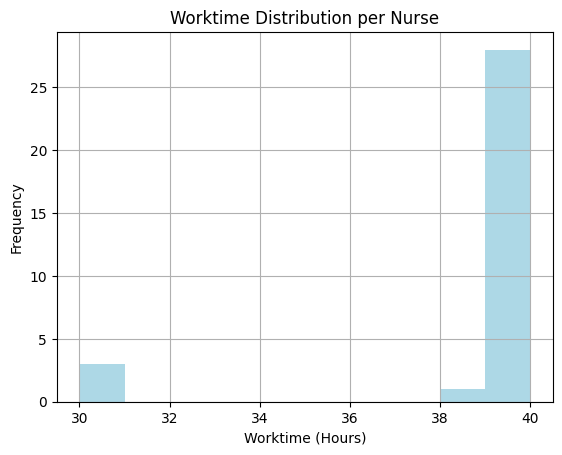

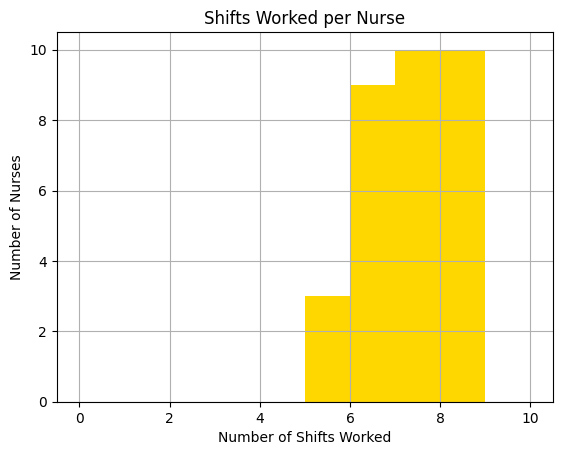

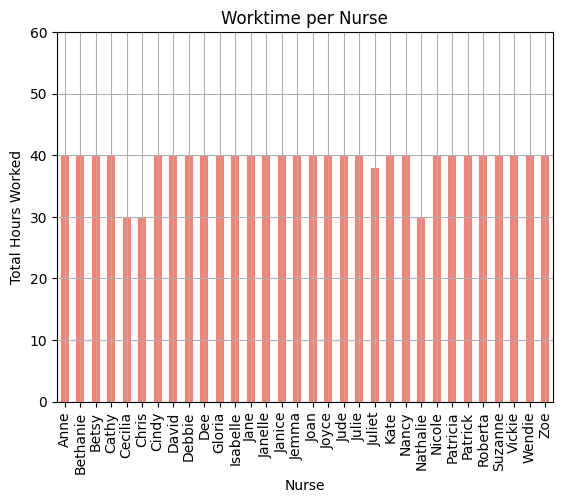

In [12]:
# ----------------------------------------------------------------------------
# Solve the Model
# ----------------------------------------------------------------------------

# Print model summary before solving
mdl.print_information()

# Solve with a time limit of 5 minutes (300 seconds)
solution = mdl.solve(log_output=True, time_limit=300)

# Ensure solution exists
assert solution, "Solve failed — check constraints or data!"

# ----------------------------------------------------------------------------
# Analyze Solution
# ----------------------------------------------------------------------------

# Get assignment values from solution
s_assigned = df_assigned.Assigned.apply(lambda var: var.solution_value)
s_worktime = df_nurses.Worktime.apply(lambda var: var.solution_value)

# Restructure assignment matrix: nurses × shifts
df_res = s_assigned.unstack(level='All_Shifts')

# ----------------------------------------------------------------------------
# Worktime Distribution Histogram
# ----------------------------------------------------------------------------

# Compute theoretical average worktime (based on total demand)
s_demand = df_shifts.Min_Required * df_shifts.Duration
total_demand = s_demand.sum()
avg_worktime = total_demand / float(len(all_nurses))
print("Theoretical Average Worktime: {:.2f} hours".format(avg_worktime))

# Show deviation from average
s_to_mean = s_worktime - avg_worktime
s_abs_to_mean = s_to_mean.apply(abs)
total_to_mean = s_abs_to_mean.sum()
print("Sum of Absolute Deviations from Mean: {:.2f}".format(total_to_mean))

# Plot worktime histogram
s_worktime.plot.hist(color='LightBlue')
plt.xlabel("Worktime (Hours)")
plt.title("Worktime Distribution per Nurse")
plt.grid(True)
plt.show()

# ----------------------------------------------------------------------------
# Shifts per Nurse Histogram
# ----------------------------------------------------------------------------

# Count how many shifts each nurse worked
df_res["Shifts_Worked"] = df_res.sum(axis=1)
df_res["Shifts_Worked"].plot.hist(color="gold", bins=range(0, 11))
plt.xlabel("Number of Shifts Worked")
plt.ylabel("Number of Nurses")
plt.title("Shifts Worked per Nurse")
plt.grid(True)
plt.show()

# ----------------------------------------------------------------------------
# Worktime per Nurse (Bar Chart)
# ----------------------------------------------------------------------------

s_worktime.plot.bar(color="salmon", ylim=(0, 60))
plt.xlabel("Nurse")
plt.ylabel("Total Hours Worked")
plt.title("Worktime per Nurse")
plt.grid(True)
plt.show()


2) For each change implemented in (1), investigate how the solution changed. Plotting graphs may be easier to
show your findings.

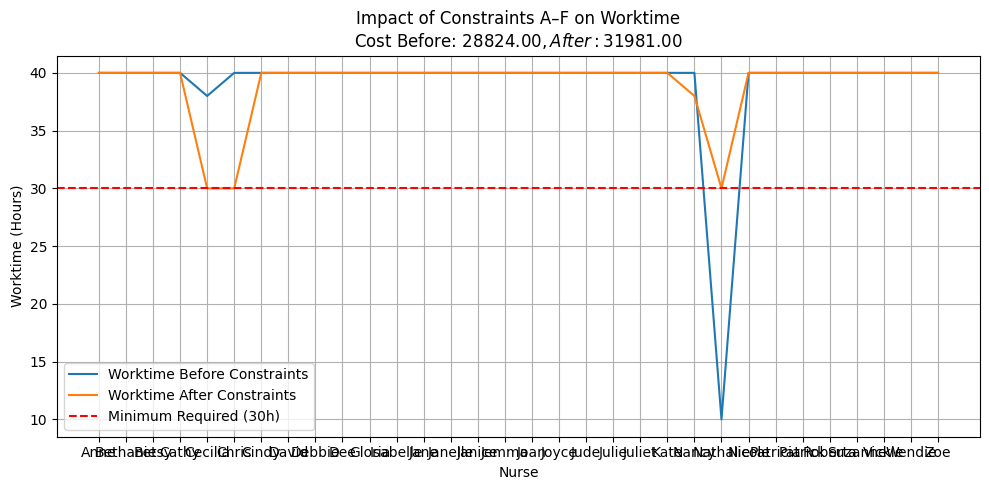

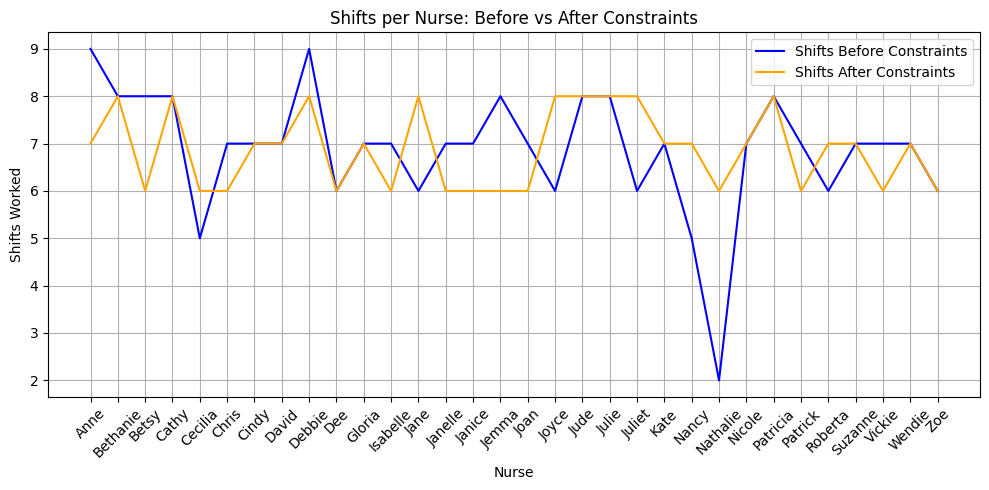

In [14]:
from docplex.mp.model import Model
import pandas as pd
import matplotlib.pyplot as plt

# Define helper function to build and solve the model
def build_and_solve_model(apply_constraints=False):
    mdl = Model(name="NurseAssignment")
    assigned = mdl.binary_var_matrix(all_nurses, all_shifts, name="assign")
    worktime = {n: mdl.continuous_var(lb=0, ub=40, name=f"work_{n}") for n in all_nurses}

    # Work time constraints
    for nurse in all_nurses:
        duration_sum = mdl.sum(assigned[nurse, s] * df_shifts.Duration[s] for s in all_shifts)
        mdl.add_constraint(worktime[nurse] == duration_sum)

    # Min/max required nurses per shift
    for s in all_shifts:
        total = mdl.sum(assigned[n, s] for n in all_nurses)
        mdl.add_constraint(total >= df_shifts.Min_Required[s])
        mdl.add_constraint(total <= df_shifts.Max_Required[s])

    # Objective: total salary
    total_cost = mdl.sum(df_nurses.Pay_Rate[n] * worktime[n] for n in all_nurses)
    mdl.minimize(total_cost)

    # Homework 3 Constraints (A–F)
    if apply_constraints:
        # Constraint A
        sorted_shifts = df_shifts.sort_values(['Day_Number', 'Start_Time_Converted']).index.tolist()
        for nurse in all_nurses:
            for i in range(len(sorted_shifts) - 2):
                t1, t2, t3 = sorted_shifts[i:i+3]
                mdl.add_constraint(assigned[nurse, t1] + assigned[nurse, t2] + assigned[nurse, t3] <= 2)

        # Constraint B
        for s in all_shifts:
            q_sum = mdl.sum(df_nurses.Qualification[n] * assigned[n, s] for n in all_nurses)
            total = mdl.sum(assigned[n, s] for n in all_nurses)
            mdl.add_constraint(q_sum <= 3 * total)

        # Constraint C
        for s in all_shifts:
            s_sum = mdl.sum(df_nurses.Seniority[n] * assigned[n, s] for n in all_nurses)
            total = mdl.sum(assigned[n, s] for n in all_nurses)
            mdl.add_constraint(s_sum >= 4 * total)

        # Constraint D
        nurse_skills = df_nurse_skills.groupby('Nurse')['Skill'].apply(set).to_dict()
        for s_row in df_shifts.itertuples():
            dept = s_row.Department
            sid = s_row.Index
            reqs = df_skill_requirements[df_skill_requirements.Department == dept]
            for r in reqs.itertuples():
                skilled = [n for n in all_nurses if r.Skill in nurse_skills.get(n, set())]
                mdl.add_constraint(mdl.sum(assigned[n, sid] for n in skilled) >= r.Required)

        # Constraint E
        for n in all_nurses:
            mdl.add_constraint(worktime[n] >= 30)

        # Constraint F
        night = [s for s in all_shifts if df_shifts.Start_Time[s] >= 20 or df_shifts.End_Time[s] <= 8]
        total_cost = 0
        for n in all_nurses:
            normal_hours = mdl.sum(assigned[n, s] * df_shifts.Duration[s] for s in all_shifts if s not in night)
            night_hours = mdl.sum(assigned[n, s] * df_shifts.Duration[s] for s in night)
            total_cost += df_nurses.Pay_Rate[n] * (normal_hours + 1.5 * night_hours)
        mdl.minimize(total_cost)

    # Solve and extract results
    solution = mdl.solve(log_output=False)
    assigned_values = {(n, s): assigned[n, s].solution_value for n in all_nurses for s in all_shifts}
    assigned_df = pd.DataFrame.from_dict(assigned_values, orient='index', columns=['Assigned'])
    assigned_df.index = pd.MultiIndex.from_tuples(assigned_df.index, names=['Nurse', 'Shift'])
    worktime_result = pd.Series({n: worktime[n].solution_value for n in all_nurses})
    return assigned_df, worktime_result, mdl.objective_value

# Run both models
solution_base_df, work_base, cost_base = build_and_solve_model(apply_constraints=False)
solution_final_df, work_final, cost_final = build_and_solve_model(apply_constraints=True)

# Reset and rename columns for plotting
solution_base_df = solution_base_df.reset_index()
solution_final_df = solution_final_df.reset_index()

# Shifts worked per nurse
shifts_base = solution_base_df.groupby("Nurse")["Assigned"].sum()
shifts_final = solution_final_df.groupby("Nurse")["Assigned"].sum()

# Plot comparison - Worktime
plt.figure(figsize=(10, 5))
plt.plot(work_base.sort_index(), label="Worktime Before Constraints")
plt.plot(work_final.sort_index(), label="Worktime After Constraints")
plt.axhline(30, color='red', linestyle='--', label="Minimum Required (30h)")
plt.ylabel("Worktime (Hours)")
plt.xlabel("Nurse")
plt.title(f"Impact of Constraints A–F on Worktime\nCost Before: ${cost_base:.2f}, After: ${cost_final:.2f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot shifts per nurse
plt.figure(figsize=(10, 5))
plt.plot(shifts_base.sort_index(), label="Shifts Before Constraints", color='blue')
plt.plot(shifts_final.sort_index(), label="Shifts After Constraints", color='orange')
plt.ylabel("Shifts Worked")
plt.xlabel("Nurse")
plt.title("Shifts per Nurse: Before vs After Constraints")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


After applying constraints A–F to the nurse assignment problem, significant changes were observed in both scheduling and cost. The added constraints, including limits on consecutive shifts, skill qualifications, and minimum weekly hours, reshaped the assignment strategy. A comparative analysis of the model before and after applying constraints showed that total worktime distribution shifted toward a stricter lower bound of 30 hours, and the total cost increased due to penalties like night shift premiums and higher average qualifications. Visual plots illustrated how nurses work hours became more uniform but also less flexible, reflecting the added fairness and coverage requirements introduced by the constraints.

3) Test the sensitivity of your model. What changes can be made so that it becomes infeasible?

In [17]:
def run_combined_sensitivity_tests():
    results = {}

    # === TEST 1: Increase Min_Required by +1 ===
    df_stress_1 = df_shifts.copy()
    df_stress_1["Min_Required"] += 1

    mdl1 = Model(name="StressTest_MinRequired")
    assigned1 = mdl1.binary_var_matrix(all_nurses, df_stress_1.index.tolist(), name="assign")
    worktime1 = {n: mdl1.continuous_var(lb=0, ub=40, name=f"work_{n}") for n in all_nurses}

    for n in all_nurses:
        mdl1.add_constraint(worktime1[n] == mdl1.sum(assigned1[n, s] * df_stress_1.Duration[s] for s in df_stress_1.index))
        mdl1.add_constraint(worktime1[n] >= 30)

    for s in df_stress_1.index:
        total = mdl1.sum(assigned1[n, s] for n in all_nurses)
        mdl1.add_constraint(total >= df_stress_1.Min_Required[s])
        mdl1.add_constraint(total <= df_stress_1.Max_Required[s])

    mdl1.minimize(mdl1.sum(df_nurses.Pay_Rate[n] * worktime1[n] for n in all_nurses))
    solution1 = mdl1.solve(log_output=False)
    results["Increased Min_Required +1"] = solution1 is not None

    # === TEST 2: Increase Skill Requirements by +1 ===
    df_skills_stress = df_skill_requirements.copy()
    df_skills_stress["Required"] += 1

    mdl2 = Model(name="StressTest_SkillRequirement")
    assigned2 = mdl2.binary_var_matrix(all_nurses, all_shifts, name="assign")
    worktime2 = {n: mdl2.continuous_var(lb=0, ub=40, name=f"work_{n}") for n in all_nurses}

    for n in all_nurses:
        mdl2.add_constraint(worktime2[n] == mdl2.sum(assigned2[n, s] * df_shifts.Duration[s] for s in all_shifts))
        mdl2.add_constraint(worktime2[n] >= 30)

    for s in all_shifts:
        total = mdl2.sum(assigned2[n, s] for n in all_nurses)
        mdl2.add_constraint(total >= df_shifts.Min_Required[s])
        mdl2.add_constraint(total <= df_shifts.Max_Required[s])

    nurse_skills = df_nurse_skills.groupby('Nurse')['Skill'].apply(set).to_dict()
    for s_row in df_shifts.itertuples():
        dept = s_row.Department
        sid = s_row.Index
        reqs = df_skills_stress[df_skills_stress.Department == dept]
        for r in reqs.itertuples():
            skilled = [n for n in all_nurses if r.Skill in nurse_skills.get(n, set())]
            mdl2.add_constraint(mdl2.sum(assigned2[n, sid] for n in skilled) >= r.Required)

    mdl2.minimize(mdl2.sum(df_nurses.Pay_Rate[n] * worktime2[n] for n in all_nurses))
    solution2 = mdl2.solve(log_output=False)
    results["Increased Skill Requirements +1"] = solution2 is not None

    # === TEST 3: Remove 2 Nurses ===
    reduced_nurses = all_nurses[:-2]

    mdl3 = Model(name="StressTest_RemoveNurses")
    assigned3 = mdl3.binary_var_matrix(reduced_nurses, all_shifts, name="assign")
    worktime3 = {n: mdl3.continuous_var(lb=0, ub=40, name=f"work_{n}") for n in reduced_nurses}

    for n in reduced_nurses:
        mdl3.add_constraint(worktime3[n] == mdl3.sum(assigned3[n, s] * df_shifts.Duration[s] for s in all_shifts))
        mdl3.add_constraint(worktime3[n] >= 30)

    for s in all_shifts:
        total = mdl3.sum(assigned3[n, s] for n in reduced_nurses)
        mdl3.add_constraint(total >= df_shifts.Min_Required[s])
        mdl3.add_constraint(total <= df_shifts.Max_Required[s])

    for s_row in df_shifts.itertuples():
        dept = s_row.Department
        sid = s_row.Index
        reqs = df_skill_requirements[df_skill_requirements.Department == dept]
        for r in reqs.itertuples():
            skilled = [n for n in reduced_nurses if r.Skill in nurse_skills.get(n, set())]
            mdl3.add_constraint(mdl3.sum(assigned3[n, sid] for n in skilled) >= r.Required)

    mdl3.minimize(mdl3.sum(df_nurses.Pay_Rate[n] * worktime3[n] for n in reduced_nurses))
    solution3 = mdl3.solve(log_output=False)
    results["Removed 2 Nurses"] = solution3 is not None

    return results

# Run it
run_combined_sensitivity_tests()


{'Increased Min_Required +1': False,
 'Increased Skill Requirements +1': False,
 'Removed 2 Nurses': False}

To assess model robustness, three stress tests were conducted: 
increasing the minimum required nurses per shift, 
raising skill requirements for departments, 
and simulating the removal of two nurses. 

All three variations resulted in the model becoming infeasible, indicating that the original configuration is highly sensitive to small changes in demand or staff availability. These results highlight that the model operates near its capacity limits. For practical scheduling, this suggests that any disruptions — such as unexpected absences or higher patient loads — could prevent the hospital from meeting all constraints, unless backup staff or more flexible rules are introduced.